In [1]:
#uncomment this to see the names of the different configurations that can be loaded in
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field1', 'Field2', 'Field3', 'Field5', 'Field6', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12', 'Field13', 'FieldA', 'FieldB', 'FieldC', 'FieldD', 'FieldE', 'FieldF', 'FieldG', 'FieldH', 'FieldI', 'FieldK', 'FieldL', 'FieldM', 'FieldO', 'FieldP', 'FieldQ', 'FieldR', 'FieldS', 'FieldT', 'FieldU', 'FieldV', 'FieldW', 'FieldX', 'FieldY', 'H_North', 'H_South', 'ArchE', 'ArchNE', 'ArchNW', 'ArchSE', 'ArchW', 'FieldA9', 'FieldB9', 'FieldC9', 'FieldF9', 'FieldI9', 'FieldL9', 'FieldN9']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [766]:
#import configuration for selected file
from config import Field5 as field #5 was first
from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

In [838]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, Table
from astropy.coordinates import SkyCoord

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

from regions import read_ds9

In [768]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(field.filename)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcs=WCS(hdu[0].header)

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

In [769]:
#load in the catalog files if they exist
if os.path.isfile(field.name+'_'+str(wavelength)+'um_segCat.dat'):
    segTab=ascii.read(field.name+'_'+str(wavelength)+'um_segCat.dat')
else:
    segTab=None
    
if os.path.isfile(field.name+'_'+str(wavelength)+'um_daoCat.dat'):   
    daoTab=ascii.read(field.name+'_'+str(wavelength)+'um_daoCat.dat')
else:
    daoTab=None

In [770]:
#Source coordinates need to be in the form of skycoord objects to create apertures. Ascii tables save as strings so this code puts them back in the right form. 
if segTab is not None:
    sourcecoords=segTab['sky_centroid']
else:
    sourcecoords=[]
scseg=[]

for coord in sourcecoords:
    pos=coord.find(",")
    ra=coord[:pos]
    dec=coord[pos+1:]
    scobj=SkyCoord(ra,dec,unit=u.deg)
    scseg.append(scobj)

if segTab is not None:
    segTab['skycoords']=scseg
    sourcesseg=segTab['skycoords']

sourcecoords=daoTab['sky_centroid']
scdao=[]

for coord in sourcecoords:
    pos=coord.find(",")
    ra=coord[:pos]
    dec=coord[pos+1:]
    scobj=SkyCoord(ra,dec,unit=u.deg)
    scdao.append(scobj)
    
daoTab['skycoords']=scdao
sourcesdao=daoTab['skycoords']

In [771]:
segTab

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,skycoords,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv
,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,str38,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,int32
1,145.4,46.46,"266.26731142939803,-29.19580033012863",-0.0124,0.03775,3.209,85,4.768,1.368,77.43,0.511,-0.2083,0.06721,0.958,0.7131,3.485,8.26,18.72,0.6293,2.643,6.775,0.1739,0.03649,0.03695,0.00951,3.721,"266.26731142939803,-29.19580033012863",7.699293745015505,0.14401396311787712,8.577885932230718,0.15480102252366307,9.505091801975974,0.16582658133050607,10.448181795989868,0.17717883929955197,11.424973670560458,0.1886734384945277,12.449543681423108,0.2003091055615619,13.528758252652821,0.21208586864718407,14.64865137448248,0.22392233977391848,15.794586735323895,0.2358193061152531,16.938693028053354,0.24783139159338882,18.096836697403994,0.25990697616181563,41.48161216220964,0.4600820345660514,0.015559489838778973,0.02986944977536161,15.113341939897836,0.25990697616181563,0.015559489838778973,191.74759509597692,830.9062454158999,7.564353582010707,6.68407677891966,7.412458292579875,8.179094131973237,8.95125473883834,9.746757869463245,10.579679779583312,11.456886893273545,12.364413200766828,13.28762239047497,14.198643155274262,15.113341939897836,33.19412672469254,5.9777976872629095,6.178680008323561,6.377411649524217,6.549409484275085,6.711176141727073,6.872842196096601,7.0379415233061975,7.197242970072135,7.342866969904573,7.461476542758571,7.564353582010707,8.761125746013343,8.761125746013343,C7Field5,37
2,130.5,46.53,"266.2709633223318,-29.19578598739382",-0.01021,0.07024,5.479,78,3.212,1.734,68.83,0.3019,-0.1587,0.1277,0.8418,0.4601,1.852,6.077,25.33,0.577,2.716,9.573,0.1599,0.06972,0.07008,0.001072,4.036,"266.2709633223318,-29.19578598739382",12.587971034087703,0.14344020101896404,14.058317380921508,0.15391572860855074,15.540971088872436,0.16448407434956133,17.041130068604406,0.17527256733229588,18.590264911171403,0.18614457947007595,20.185653946875117,0.197100945

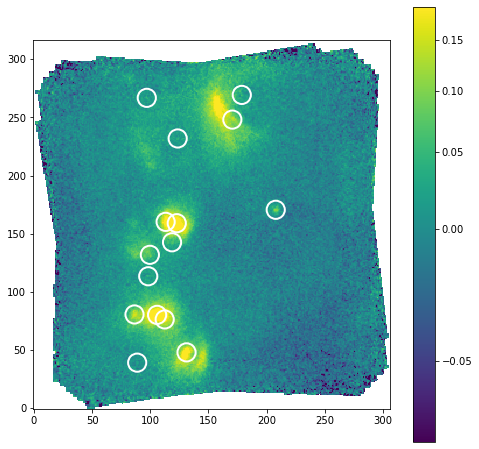

In [772]:
#show figure with sources identified
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

aperture =SkyCircularAperture(daoTab['skycoords'], r=6*u.arcsec) #define apertures for plot
pix_aperture = aperture.to_pixel(wcs)

ap_patches = pix_aperture.plot(color='white', lw=2,
                          label='Photometry aperture')
#ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
#                                    label='Background annulus')
#handles = (ap_patches[0], ann_patches[0])
#plt.legend(loc='best', facecolor='#458989', labelcolor='white',
#           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

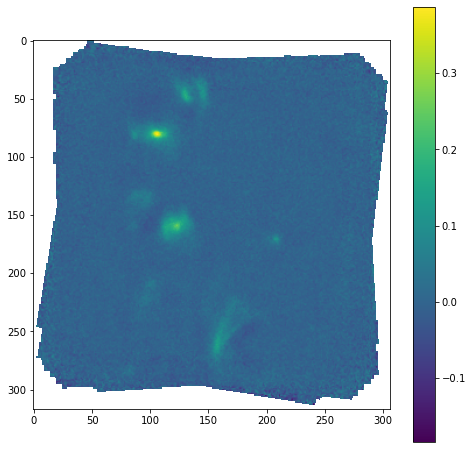

In [773]:
#create background model for image using median method
bkg_estimator = MedianBackground() #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(bkgbox, bkgbox), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg


plt.figure(figsize=(8,8))
plt.imshow(data_bkgsub)
plt.colorbar()
plt.show()


In [774]:
import scipy.optimize as opt
from astropy.nddata.utils import Cutout2D

In [775]:
def Gaussian2D(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x,y)=xdata_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2))) + offset
    return g.ravel()

def Gaussian2Dfixedpos(xdata_tuple, amplitude, sigma_x, sigma_y, theta, offset):
    (x,y)=xdata_tuple  
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-csize/2.0)**2) + 2*b*(x-csize/2.0)*(y-csize/2.0) + c*((y-csize/2.0)**2))) + offset
    return g.ravel()

In [845]:
def doGaussian2DModel(Tab,size,plot=False):
    cutouts=[]
    residuals=[]
    varcuts=[]
    params=[]
    for i in range(len(Tab)):

        psloc=(int(np.round(Tab['xcentroid'][i])),int(np.round(Tab['ycentroid'][i])))
        cutout = Cutout2D(data_bkgsub, psloc, (size, size))
        varcut = Cutout2D(varmap, psloc, (size, size))
        # add some noise to the data and try to fit the data generated beforehand
        initial_guess = (Tab["aperture_sum_3.5as"][i]/62.,int(size/2.0),int(size/2.0),4,4,0,0)

        # Create x and y indices
        x = np.linspace(0, size-1, size)
        y = np.linspace(0, size-1, size)
        x, y = np.meshgrid(x, y)
        
        #try fit with all parameters allowed to vary
        try:
            popt, pcov = opt.curve_fit(Gaussian2D, (x, y), cutout.data.ravel(), p0=initial_guess)
            qflag=0
        except RuntimeError:
            popt=[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
            
        data_fitted = Gaussian2D((x, y), *popt)
        
        
        #if fit fails then try running with fixed position     
        if popt[0] is np.nan:
            ig2 = (Tab["aperture_sum_3.5as"][i]/62.,4,4,0,0.15)
            try:
                popt, pcov = opt.curve_fit(Gaussian2Dfixedpos, (x, y), cutout.data.ravel(), p0=ig2)
                data_fitted = Gaussian2Dfixed((x, y), *popt)
                qflag=1
            except RuntimeError:
                popt=[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
                qflag=3
                
        '''
        xfit=int(size/2.0)-popt[1]
        yfit=int(size/2.0)-popt[2]

        #if it seems like we're at the wrong source try refittingn at center  
        if np.abs(xfit)>6. or np.abs(yfit)>6.:
            ig2 = (Tab["aperture_sum_3.5as"][i]/62.,4,4,0,0.15)
            try:
                popt, pcov = opt.curve_fit(Gaussian2Dfixedpos, (x, y), cutout.data.ravel(), p0=ig2)
                data_fitted = Gaussian2Dfixed((x, y), *popt)
                qflag=2
            except RuntimeError:
                #popt=[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
                donothing=1
                qflag=4
        '''
            
        residual = cutout.data - data_fitted.reshape(size, size)
        fiterr=np.sqrt(np.diagonal(pcov)*np.sum(residual**2)/(np.shape(cutout.data.ravel())[0]-5))
        
        if qflag==0:
            
            volume = 2*np.pi*np.sqrt(np.abs(popt[3]))*np.sqrt(np.abs(popt[4]))
            volerr = 2*np.pi*np.sqrt((fiterr[3]/popt[3])+(fiterr[4]/popt[4]))
            xfwhm=np.abs(popt[3])*2.355
            xfwhmerr=np.abs(fiterr[3])*2.355
            yfwhm=np.abs(popt[4])*2.355
            yfwhmerr=np.abs(fiterr[4])*2.355
            fitAmp=popt[0]
            fitAmperr=fiterr[0]
            xfit=int(size/2.0)-popt[1]
            xfiterr=fiterr[1]
            yfit=int(size/2.0)-popt[2]
            yfiterr=fiterr[2]
            theta=popt[5]
            theta_err=fiterr[5]
            dcOffset=popt[6] 
            dco_err=fiterr[6]
        else:

            volume = 2*np.pi*np.sqrt(np.abs(popt[1]))*np.sqrt(np.abs(popt[2]))
            volerr = 2*np.pi*np.sqrt((fiterr[1]/popt[1])+(fiterr[2]/popt[2]))
            xfwhm=np.abs(popt[1])*2.355
            xfwhmerr=np.abs(fiterr[1])*2.355
            yfwhm=np.abs(popt[2])*2.355
            yfwhmerr=np.abs(fiterr[2])*2.355
            fitAmp=popt[0]
            fitAmperr=fiterr[0]
            xfit=0
            xfiterr=0
            yfit=0
            yfiterr=0
            theta=popt[3]
            theta_err=fiterr[3]
            dcOffset=popt[4]
            dco_err=fiterr[4]
        
        if plot and popt[0] is not np.nan:
            fig, ax = plt.subplots(1, 1)
            #ax.hold(True)
            ax.imshow(cutout.data, cmap=plt.cm.jet, origin='lower',
                extent=(x.min(), x.max(), y.min(), y.max()))
            ax.contour(x, y, data_fitted.reshape(size,size), 4, colors='w')
            plt.show()


        model=[volume,volerr,xfwhm,xfwhmerr,yfwhm,yfwhmerr,fitAmp,fitAmperr,xfit,xfiterr,yfit,yfiterr,theta,theta_err,
               dcOffset,dco_err,qflag]
        
        cutouts.append(cutout.data)
        residuals.append(residual)
        varcuts.append(varcut.data)
        params.append(model)
        
        
    return cutouts,residuals,varcuts,np.array(params)
    

In [846]:
cuts,resid,vcuts,modpar = doGaussian2DModel(segTab,11)
segTab['Cutouts']=cuts
segTab['VarCutout']=vcuts
segTab['Residuals']=resid
segTab['PSF_FLUX']=modpar[:,0]
segTab['PSF_FLUX_ERR']=modpar[:,1]
segTab['PSF_XFWHM']=modpar[:,2]
segTab['PSF_XFWHM_ERR']=modpar[:,3]
segTab['PSF_YFWHM']=modpar[:,4]
segTab['PSF_yFWHM_ERR']=modpar[:,5]
segTab['PSF_FitAmp']=modpar[:,6]
segTab['PSF_FitAmpERR']=modpar[:,7]
segTab['PSF_XFIT']=modpar[:,8]
segTab['PSF_XFIT_ERR']=modpar[:,9]
segTab['PSF_YFIT']=modpar[:,10]
segTab['PSF_YFIT_ERR']=modpar[:,11]
segTab['PSF_THETA']=modpar[:,12]
segTab['PSF_THETA_ERR']=modpar[:,13]
segTab['PSF_DCOFF']=modpar[:,14]
segTab['PSF_DCO_ERR']=modpar[:,15]
segTab['PSF_QFLAG']=modpar[:,16]

In [847]:
segTab

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,skycoords,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv,"Cutouts [11,11]","VarCutout [11,11]","Residuals [11,11]",PSF_FLUX,PSF_XFWHM,PSF_YFWHM,PSF_FitAmp,PSF_XFIT,PSF_YFIT,PSF_THETA,PSF_DCOFF,PSF_QFLAG,PSF_FLUX_ERR,PSF_XFWHM_ERR,PSF_yFWHM_ERR,PSF_FitAmpERR,PSF_XFIT_ERR,PSF_YFIT_ERR,PSF_THETA_ERR,PSF_DCO_ERR
,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,str38,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,int32,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,145.4,46.46,"266.26731142939803,-29.19580033012863",-0.0124,0.03775,3.209,85,4.768,1.368,77.43,0.511,-0.2083,0.06721,0.958,0.7131,3.485,8.26,18.72,0.6293,2.643,6.775,0.1739,0.03649,0.03695,0.00951,3.721,"266.26731142939803,-29.19580033012863",7.699293745015505,0.14401396311787712,8.577885932230718,0.15480102252366307,9.505091801975974,0.16582658133050607,10.448181795989868,0.17717883929955197,11.424973670560458,0.1886734384945277,12.449543681423108,0.2003091055615619,13.528758252652821,0.21208586864718407,14.64865137448248,0.22392233977391848,15.794586735323895,0.2358193061152531,16.938693028053354,0.24783139159338882,18.096836697403994,0.25990697616181563,41.48161216220964,0.4600820345660514,0.015559489838778973,0.02986944977536161,15.113341939897836,0.25990697616181563,0.015559489838778973,191.74759509597692,830.9062454158999,7.564353582010707,6.68407677891966,7.412458292579875,8.179094131973237,8.95125473883834,9.746757869463245,10.579679779583312,11.456886893273545,12.364413200766828,13.28762239047497,14.198643155274262,15.113341939897836,33.19412672469254,5.9777976872629095,6.178680008323561,6.377411649524217,6.549409484275085,6.711176141727073,6.872842196096601,7.0379415233061975,7.197242970072135,7.342866969904573,7.461476542758571,7.564353582010707,8.761125746013343,8.761125746013343,C7Field5,37,0.05743380591303766 .. 0.0273695025000

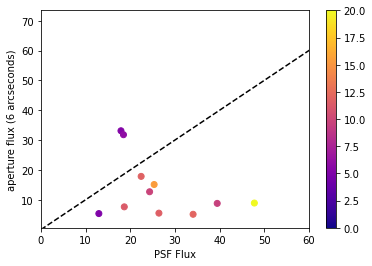

In [832]:
plt.figure
plt.scatter(segTab['PSF_FLUX'],segTab['aper_sum_bkgsub_6.0as'],c=(segTab['PSF_YFWHM']+segTab['PSF_YFWHM'])/2., cmap='plasma',vmin=0,vmax=20)
plt.colorbar()
plt.plot([0,70],[0,70],'k--')
plt.xlabel('PSF Flux')
plt.ylabel('aperture flux (6 arcseconds)')

plt.xlim(0,60)
plt.ylim(0.60)

plt.show()

In [833]:
cuts,resid,vcuts,modpar = doGaussian2DModel(daoTab,11)
daoTab['Cutouts']=cuts
daoTab['Residuals']=resid
daoTab['VarCutout']=vcuts
daoTab['PSF_FLUX']=modpar[:,0]
daoTab['PSF_FLUX_ERR']=modpar[:,1]
daoTab['PSF_XFWHM']=modpar[:,2]
daoTab['PSF_XFWHM_ERR']=modpar[:,3]
daoTab['PSF_YFWHM']=modpar[:,4]
daoTab['PSF_yFWHM_ERR']=modpar[:,5]
daoTab['PSF_FitAmp']=modpar[:,6]
daoTab['PSF_FitAmpERR']=modpar[:,7]
daoTab['PSF_XFIT']=modpar[:,8]
daoTab['PSF_XFIT_ERR']=modpar[:,9]
daoTab['PSF_YFIT']=modpar[:,10]
daoTab['PSF_YFIT_ERR']=modpar[:,11]
daoTab['PSF_THETA']=modpar[:,12]
daoTab['PSF_THETA_ERR']=modpar[:,13]
daoTab['PSF_DCOFF']=modpar[:,14]
daoTab['PSF_DCO_ERR']=modpar[:,15]
daoTab['PSF_QFLAG']=modpar[:,16]

<ipython-input-829-d1d0f5d1dec1>:63: RuntimeWarning: invalid value encountered in sqrt
  volerr = 2*np.pi*np.sqrt((fiterr[3]/popt[3])+(fiterr[4]/popt[4]))
C:\Users\mhankins1\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-829-d1d0f5d1dec1>:81: RuntimeWarning: invalid value encountered in double_scalars
  volerr = 2*np.pi*np.sqrt((fiterr[1]/popt[1])+(fiterr[2]/popt[2]))


In [834]:
daoTab

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,sky_centroid,skycoords,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv,"Cutouts [11,11]","Residuals [11,11]","VarCutout [11,11]",PSF_FLUX,PSF_XFWHM,PSF_YFWHM,PSF_FitAmp,PSF_XFIT,PSF_YFIT,PSF_THETA,PSF_DCOFF,PSF_QFLAG,PSF_FLUX_ERR,PSF_XFWHM_ERR,PSF_yFWHM_ERR,PSF_FitAmpERR,PSF_XFIT_ERR,PSF_YFIT_ERR,PSF_THETA_ERR,PSF_DCO_ERR
,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,str38,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,int32,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,88.82,39.09,0.37,0.05372,0.4951,25,0,0.01766,1.123,-0.126,"266.2811419764926,-29.197371842274052","266.2811419764926,-29.197371842274052",0.4434660964273159,0.1663825177994752,0.5122107656519798,0.1784859560440502,0.5733713561247719,0.1906094505899631,0.6409957826488673,0.202740214877211,0.7283471987806471,0.2148914500523364,0.8381834183873007,0.22711181906714747,0.9507066307236074,0.2393546076152031,1.073905013467107,0.25160546205175843,1.2041252013688952,0.263897948636127,1.3458450052213347,0.27621330518613546,1.4975892902282162,0.2885596580733569,5.208435344402847,0.4856665257359791,0.010441208258271217,0.012572524247648192,-0.5044872831915436,0.2885596580733569,0.010441208258271217,191.74759509597692,830.9062454158999,-0.3004580506320799,-0.23779607091690805,-0.26985039584011383,-0.3164404542840103,-0.363518331445422,-0.39782087376796776,-0.4165902673844583,-0.43962432304011495,-0.45893486305739645,-0.4781752526852083,-0.49286768113118806,-0.5044872831915436,-0.3528884706520425,-0.24870385418812846,-0.263707051254681,-0.28993023938465595,-0.31321072250633236,-0.3231925015805492,-0.3198666521200118,-0.3197074933191497,-0.3167158097148234,-0.31369507374878614,-0.3078522661072535,-0.3004580506320799,-0.1120237608530467,-0.1120237608530467,C7Field5,37,-0.005642796957017299 .. 0.0017348882675581045,-0.008827492756872885 .. 0.0077335588614726725,0.0005127408 .. 0.00033051512,3804.292292586246,193.20720654615903,10523.16838193599,-2.5873182753189496,509.34956729509594,-1244.0421276323736,-0.38989902830555195,2.463085250282144,0.0,nan,442.2344038289022,52614.42998871263,11.200296104078227,4849.4863188140225,11803.65589823626,0.0035017630261906327,11.299417489952338
2,131.2,47.93,0.3398,0.4927,0

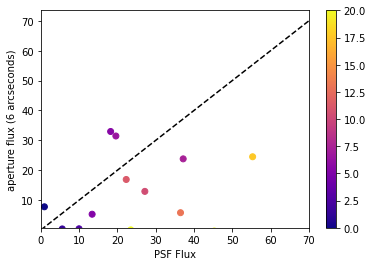

In [835]:
plt.figure
plt.scatter(daoTab['PSF_FLUX'],daoTab['aper_sum_bkgsub_6.0as'],c=(daoTab['PSF_YFWHM']+daoTab['PSF_YFWHM'])/2., cmap='plasma',vmin=0,vmax=20)
plt.colorbar()
plt.plot([0,70],[0,70],'k--')
plt.xlabel('PSF Flux')
plt.ylabel('aperture flux (6 arcseconds)')

plt.xlim(0,70)
plt.ylim(0.70)

plt.show()

In [836]:
segTab.write(field.name+'_'+str(wavelength)+'um_segCat_psf.fits') 
daoTab.write(field.name+'_'+str(wavelength)+'um_daoCat_psf.fits') 

In [843]:
testread = Table.read(field.name+'_'+str(wavelength)+'um_segCat_psf.fits')

In [844]:
testread

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,skycoords,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv,"Cutouts [11,11]","VarCutout [11,11]","Residuals [11,11]",PSF_FLUX,PSF_XFWHM,PSF_YFWHM,PSF_FitAmp,PSF_XFIT,PSF_YFIT,PSF_THETA,PSF_DCOFF,PSF_QFLAG,PSF_FLUX_ERR,PSF_XFWHM_ERR,PSF_yFWHM_ERR,PSF_FitAmpERR,PSF_XFIT_ERR,PSF_YFIT_ERR,PSF_THETA_ERR,PSF_DCO_ERR
,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,bytes38,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes8,int32,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,145.4,46.46,"266.26731142939803,-29.19580033012863",-0.0124,0.03775,3.209,85,4.768,1.368,77.43,0.511,-0.2083,0.06721,0.958,0.7131,3.485,8.26,18.72,0.6293,2.643,6.775,0.1739,0.03649,0.03695,0.00951,3.721,"266.26731142939803,-29.19580033012863",7.699293745015505,0.14401396311787712,8.577885932230718,0.15480102252366307,9.505091801975974,0.16582658133050607,10.448181795989868,0.17717883929955197,11.424973670560458,0.1886734384945277,12.449543681423108,0.2003091055615619,13.528758252652821,0.21208586864718407,14.64865137448248,0.22392233977391848,15.794586735323895,0.2358193061152531,16.938693028053354,0.24783139159338882,18.096836697403994,0.25990697616181563,41.48161216220964,0.4600820345660514,0.015559489838778973,0.02986944977536161,15.113341939897836,0.25990697616181563,0.015559489838778973,191.74759509597692,830.9062454158999,7.564353582010707,6.68407677891966,7.412458292579875,8.179094131973237,8.95125473883834,9.746757869463245,10.579679779583312,11.456886893273545,12.364413200766828,13.28762239047497,14.198643155274262,15.113341939897836,33.19412672469254,5.9777976872629095,6.178680008323561,6.377411649524217,6.549409484275085,6.711176141727073,6.872842196096601,7.0379415233061975,7.197242970072135,7.342866969904573,7.461476542758571,7.564353582010707,8.761125746013343,8.761125746013343,C7Field5,37,0.05743380591303766 .. 0.027369502

In [783]:
def Gaussian2Dfixed(xdata_tuple, amplitude, sigma_x, sigma_y, theta, offset):
    (x,y)=xdata_tuple  
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-csize/2.0)**2) + 2*b*(x-csize/2.0)*(y-csize/2.0) + c*((y-csize/2.0)**2))) + offset
    return g.ravel()

In [819]:
sourcenum=5
csize=11
psloc=(int(np.round(daoTab['xcentroid'][sourcenum])),int(np.round(daoTab['ycentroid'][sourcenum])))
#psloc
cutout = Cutout2D(data_bkgsub, psloc, (csize, csize))

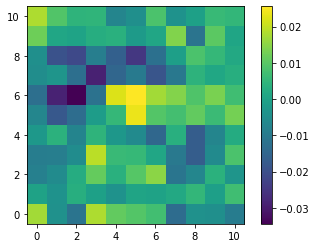

In [820]:
plt.figure()

norm2 = simple_norm(cutout.data, 'sqrt', percent=99)
plt.imshow(cutout.data,origin='lower')
plt.colorbar()
plt.show()

In [821]:
# add some noise to the data and try to fit the data generated beforehand
initial_guess = (0.1,4,4,0,0)

# Create x and y indices
x = np.linspace(0, csize-1, csize)
y = np.linspace(0, csize-1, csize)
x, y = np.meshgrid(x, y)


popt, pcov = opt.curve_fit(Gaussian2Dfixed, (x, y), cutout.data.ravel(), p0=initial_guess)

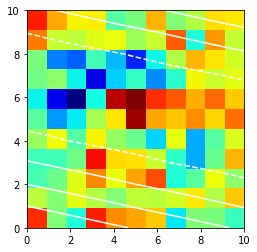

In [822]:
data_fitted = Gaussian2Dfixed((x, y), *popt)

fig, ax = plt.subplots(1, 1)
#ax.hold(True)
ax.imshow(cutout.data, cmap=plt.cm.jet, origin='lower',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(csize,csize), 4, colors='w')
plt.show()

In [823]:
pcov[0,0]
pcov[1,1]
pcov[2,2]
pcov[3,3]
pcov[4,4]#/(np.shape(cutout.data.ravel())[0]-5)


0.006026044793772754

In [824]:
np.sqrt(np.diagonal(pcov)*np.sum(residual**2)/(np.shape(cutout.data.ravel())[0]-5))

array([1.49311109e-03, 3.08201779e+07, 3.71270890e-01, 6.37057025e-03,
       1.51195905e-03])

In [825]:
residual = cutout.data - data_fitted.reshape(csize, csize)

<function matplotlib.pyplot.show(close=None, block=None)>

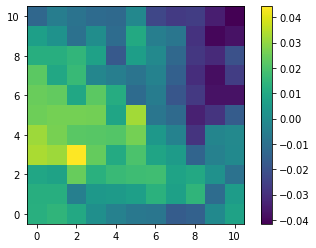

In [790]:
plt.figure()
plt.imshow(residual,origin='lower')
plt.colorbar()
plt.show

In [659]:
vol = 2*np.pi*np.sqrt(np.abs(popt[1]))*np.sqrt(np.abs(popt[2]))
vol

24.19576382925517

In [655]:
np.sum(residual**2)

0.060194657342312184

In [656]:
np.sum(cutout.data**2)

1.3001887222494428

In [657]:
xfwhm=np.abs(popt[3])*2.355
yfwhm=np.abs(popt[4])*2.355

In [658]:
xfwhm,yfwhm

(1.1209929376416028, 0.06429133276793103)

In [473]:
np.sum((cutout.data-popt[-1])**2)

0.11520269

In [474]:
popt[-1]

0.05545820156900062

In [475]:
np.std(cutout.data)

0.0153299915